# Introduction
This notebook explores the relationship between real (but anonymized) manufacturing parameters/features against a business target Y. It has been suspected that certain features in the manufacturing process has a high correlation, potentially causation, on high Ys, which is what we are trying to avoid.  

In this exercise, I will characterize the relationship between the feature and the target by: 
* Performing a linear regression on a non-linear transformation on the feeature
    * The statistical results will be assessed to determine the feature's correlation strength
* Create classification models and characterize how a range of feature values affect the probability of having high cycle times

# Data
| Variable Name | Type |
| ------------- | ---- |
| A through E   | Real numerical features: anonymized for this sample notebook. |
| Line          | Categorical feature: values can be L1 or L4. **We will only look at data points in L4 in this notebook**. |
| Class         | Categorical target: numerical thresholds were used to assign class labels to the target, used in classification models.
| Y             | Numerical target: numerical target used in regression models.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option("display.max_columns",500)

from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score,train_test_split,StratifiedKFold
from sklearn.grid_search import GridSearchCV

import statsmodels.api as sm

Let's visualize how the features and targets interact with each other.

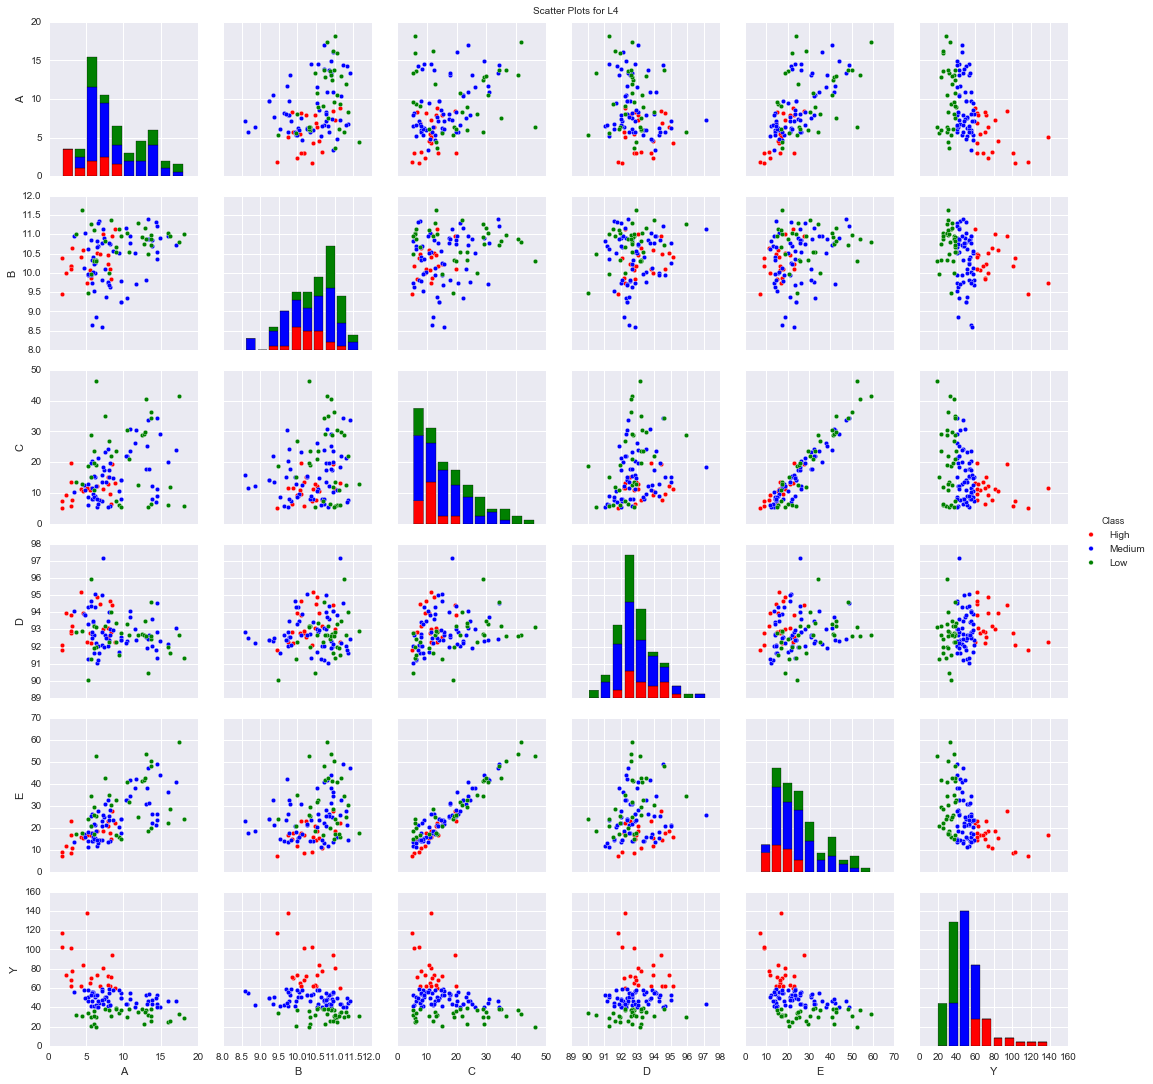

In [14]:
sns.pairplot(data=df[df['Line']=='L4'],hue='Class',palette={'High':'r','Medium':'b','Low':'g'})
plt.suptitle('Scatter Plots for L4',x=0.5,y=1.0)

# Linear Regression

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     52.13
Date:                Tue, 18 Oct 2016   Prob (F-statistic):           6.90e-11
Time:                        13:13:51   Log-Likelihood:                -470.29
No. Observations:                 113   AIC:                             944.6
Df Residuals:                     111   BIC:                             950.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         31.7408      2.894     10.969      0.0

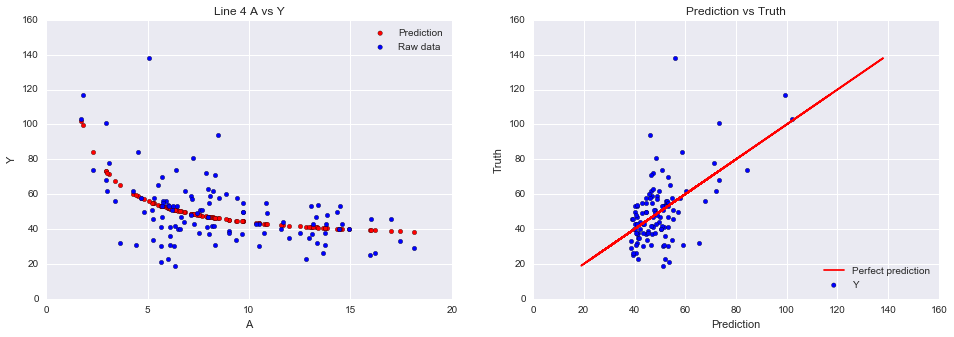

In [37]:
# Defining features and target
tempdf = pd.DataFrame()
tempdf['1/A'] = 1/df[df['Line']=='L4']['A']

# It was found that 1/B was statistically insignificant, so we are excluding it.
# tempdf['1/B'] = 1/df[df['Line']=='L4']['B'] 

features = tempdf
features = sm.add_constant(features)
target = df[df['Line']=='L4']['Y']

# Fitting model
model = sm.OLS(target, features)
results = model.fit()
pred = results.predict(features)
print results.summary()

# Plotting prediction and real for A vs Y
figure,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
axes[0].set_title('Line 4 A vs Y')
axes[0].scatter(df[df['Line']=='L4']['A'],pred,c='r',label='Prediction')
axes[0].scatter(df[df['Line']=='L4']['A'],df[df['Line']=='L4']['Y'],c='b',label='Raw data')
axes[0].set_xlabel('A'); axes[0].set_ylabel('Y'); axes[0].legend()

# Prediction vs real
axes[1].set_title('Prediction vs Truth')
axes[1].scatter(pred,df[df['Line']=='L4']['Y'])
axes[1].plot(df[df['Line']=='L4']['Y'],df[df['Line']=='L4']['Y'],c='r',label='Perfect prediction')
axes[1].set_xlabel('Prediction'); axes[1].set_ylabel('Truth'); axes[1].legend(loc='lower right')

print "RMSE:", np.sqrt(metrics.mean_squared_error(df[df['Line']=='L4']['Y'],pred))

1/A was found to be a statistically significant predictor for Y. The equation is Y = 122.49*(1/A) + 31.74. R-Squared is 0.32, which can be interpreted as 32% of the variation in Y is explained by 1/A. However, caution should be exercised when interpretting R-Squared and p-values as a feature's ability to predict Y.

Regressions are useful in visualizing trends but most of the time in biologics, there are so much variation anyways that building a model to predict a particular value is not that important. What's more interesting is whether we can identify conditions where anomalies happen. If we categorize our data into normal vs abnormal data points, we can build a classifier model and use it to characterize the conditions that favor abnormal data points.

# Classification
The following thresholds were used to assign classes to the target Y variable:
* High: when Y is greater than 60
* Medium: when Y is between 60 and 40
* Low: when Y is  below 40

In this study, we want to know under what conditions favor the "High" class so we can avoid it. High in this case are anomalies that we want to avoid. Let's try to see if we can build a classifer that can detect "Highs" and see if we can use the model to characterize the chances of "Highs" happening under different condictions.

The features we are using were selected in another exercise where my colleague's domain knowledge was the main deciding factor.

### Helper Functions

A convenient plotting function.

In [53]:
def plot_pred_prob(model,x,fileName=None):
    cols = x.columns

    for foi in cols:
        pred_prob = model.predict_proba(cartesian(x,foi))

        plt.figure(figsize=(10,7))
        plt.plot(np.linspace(min(x[foi]),max(x[foi]),num=len(pred_prob)),pred_prob[:,0],label='High',c='r')
        plt.plot(np.linspace(min(x[foi]),max(x[foi]),num=len(pred_prob)),pred_prob[:,2],label='Medium',c='b')
        plt.plot(np.linspace(min(x[foi]),max(x[foi]),num=len(pred_prob)),pred_prob[:,1],label='Low',c='g')
        plt.xlabel(foi); plt.ylabel('Probability'); plt.legend()
    
        if fileName != None:
            plt.savefig(fileName+' '+foi+'.jpg',dpi=150,format='jpeg')
            
    return None

After we get a classifer that we are comfortable with, we can feed in a range of values as our features and it will return probabilities of different classes at each data point. Plotting these probabilities allow us to see under what conditions the "high" class occur the most frequently, and thus we can avoid those conditions in our process. The following function varies a "feature of interest" (foi) over a range of values while holding other features constant at their means and returns the values in a dataframe.

In [50]:
def cartesian(x,foi):
    '''
    Take a dataframe x and a feature of interest (foi) and return a new dataframe
    with individual means for all other features except for foi, where it is a linspace of len(df)
    with min(foi) and max(foi) as the range
    '''
    tempdf = pd.DataFrame()
    tempdf_len = len(x)
    cols = x.columns

    for i in cols:
        if i != foi:
            tempdf[i] = [np.mean(x[i])] * tempdf_len
        else:
            tempdf[i] = np.linspace(min(x[i]),max(x[i]),num=tempdf_len)
    return tempdf

### Setting up the data set

In [90]:
# Transforming features

# Our study only looks at Line 4
L4_features = df[df['Line']=='L4'][['A','C']]
L4_target = df[df['Line']=='L4']['Class']

# Getting training and testing sets
L4_x_train,L4_x_test,L4_y_train,L4_y_test = train_test_split(L4_features,L4_target,stratify=L4_target,
                                                             random_state=123,test_size=0.33)

# Getting the KFolds
L4_kf = StratifiedKFold(L4_target,n_folds=3,random_state=123)

print Counter(L4_target)

Counter({'Medium': 60, 'Low': 32, 'High': 21})


We will use both cross validation and train-test-split to assess different models performances. As you can see, we have a problem of imbalance classes. This will be somewhat mitigated by passing a "balanced" keyword to the algorithm's class_weights parameter.

## Model Fitting
Various classification models will be ran with cross validation to see which one performs the best. A held out set of data will be used to further assess the model's classification performance by looking at the precision and recall scores.

### Logistic Regression

Cross validation score: 0.522522522523
             precision    recall  f1-score   support

       High       0.75      0.43      0.55         7
        Low       0.55      0.55      0.55        11
     Medium       0.61      0.70      0.65        20

avg / total       0.62      0.61      0.60        38

Accuracy score: 0.605263157895


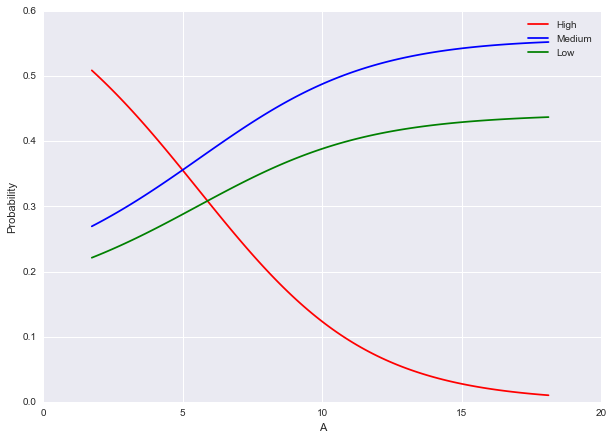

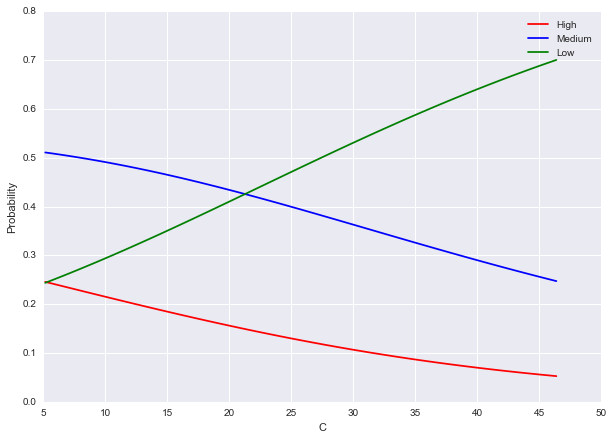

In [91]:
def Run_Logistic_Regression(features,target,kf,x_train,x_test,y_train,y_test,fileName=None):
    model = LogisticRegression(class_weight='balanced',random_state=1)

    print 'Cross validation score:',np.mean(cross_val_score(model,features,target,cv=kf))

    model.fit(x_train,y_train)
    pred = model.predict(x_test)

    print metrics.classification_report(y_test,pred)
    print 'Accuracy score:',metrics.accuracy_score(y_test,pred)
    plot_pred_prob(model,features,fileName)

Run_Logistic_Regression(L4_features,L4_target,L4_kf,L4_x_train,L4_x_test,L4_y_train,L4_y_test)

### SVM

Cross validation score: 0.477714556662
             precision    recall  f1-score   support

       High       0.50      0.57      0.53         7
        Low       0.54      0.64      0.58        11
     Medium       0.65      0.55      0.59        20

avg / total       0.59      0.58      0.58        38

Accuracy score: 0.578947368421


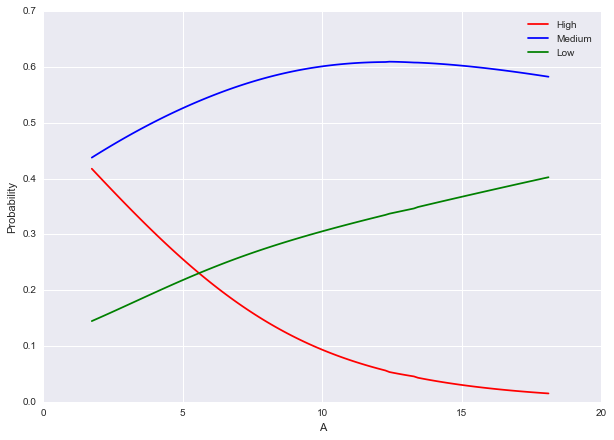

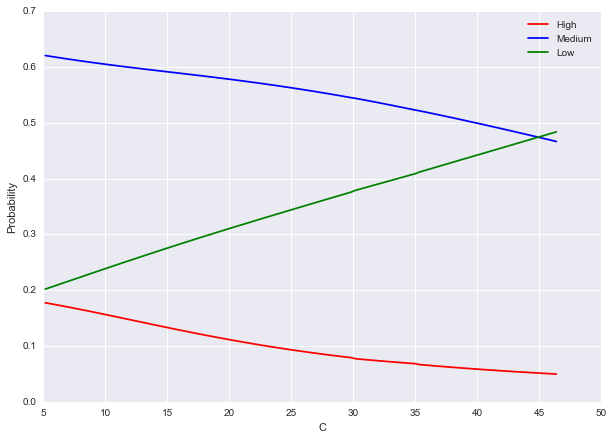

In [92]:
def Run_SVM(features,target,kf,x_train,x_test,y_train,y_test):
    model = SVC(kernel='linear',probability=True,class_weight='balanced')
    # model = OneVsRestClassifier(model)

    print 'Cross validation score:',np.mean(cross_val_score(model,features,target,cv=kf))

    model.fit(x_train,y_train)
    pred = model.predict(x_test)

    print metrics.classification_report(y_test,pred)
    print 'Accuracy score:',metrics.accuracy_score(y_test,pred)
    plot_pred_prob(model,features)

Run_SVM(L4_features,L4_target,L4_kf,L4_x_train,L4_x_test,L4_y_train,L4_y_test)

### Naive Bayes

Cross validation score: 0.460170697013
             precision    recall  f1-score   support

       High       0.57      0.57      0.57         7
        Low       0.62      0.45      0.53        11
     Medium       0.61      0.70      0.65        20

avg / total       0.61      0.61      0.60        38

Accuracy score: 0.605263157895


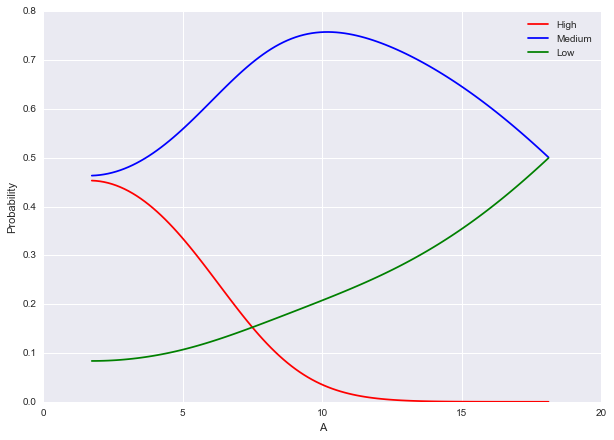

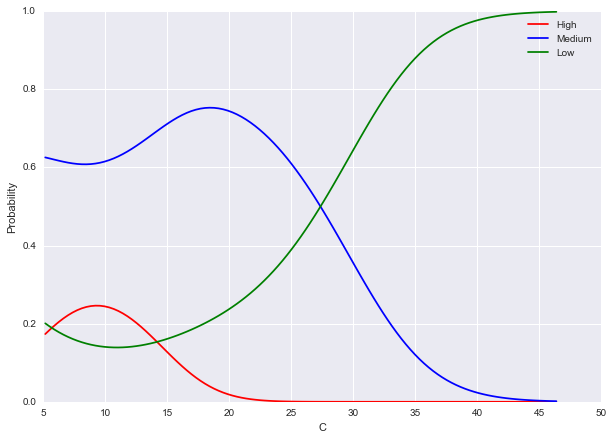

In [93]:
def Run_NB(features,target,kf,x_train,x_test,y_train,y_test):
    model = GaussianNB()
    # model = OneVsRestClassifier(model)
    print 'Cross validation score:',np.mean(cross_val_score(model,features,target,cv=kf))

    model.fit(x_train,y_train)
    pred = model.predict(x_test)

    print metrics.classification_report(y_test,pred)
    print 'Accuracy score:',metrics.accuracy_score(y_test,pred)
    plot_pred_prob(model,features)

Run_NB(L4_features,L4_target,L4_kf,L4_x_train,L4_x_test,L4_y_train,L4_y_test)

### Random Forest
While Random Forest generally work well, they tend to overfit. To mitigate this, I'm using a large number of trees and max_feature of 1. I am also iterating over a series of max_depth parameters and select the most parsimonious model.

Depth: 2
Cross validation score: 0.459933617828
             precision    recall  f1-score   support

       High       0.50      0.43      0.46         7
        Low       0.50      0.36      0.42        11
     Medium       0.54      0.65      0.59        20

avg / total       0.52      0.53      0.52        38

Accuracy score: 0.526315789474

Depth: 3
Cross validation score: 0.486723565671
             precision    recall  f1-score   support

       High       0.67      0.29      0.40         7
        Low       0.62      0.45      0.53        11
     Medium       0.59      0.80      0.68        20

avg / total       0.62      0.61      0.58        38

Accuracy score: 0.605263157895

Depth: 4
Cross validation score: 0.513276434329
             precision    recall  f1-score   support

       High       1.00      0.14      0.25         7
        Low       0.57      0.36      0.44        11
     Medium       0.57      0.85      0.68        20

avg / total       0.65      0.58      0.53

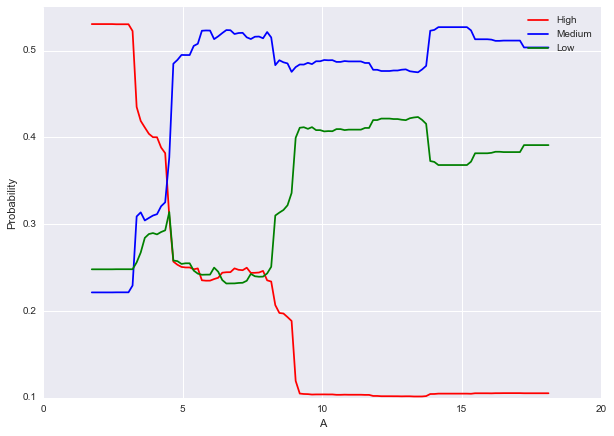

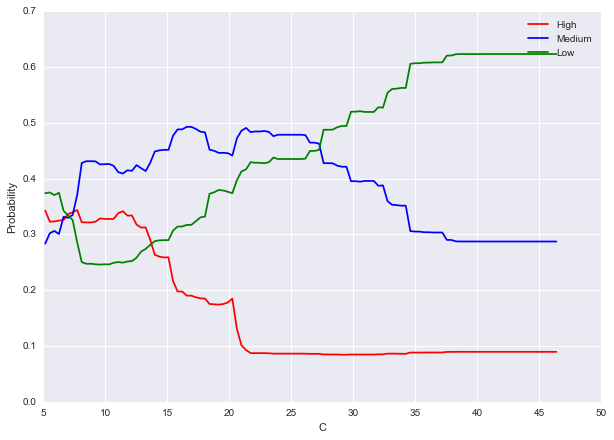

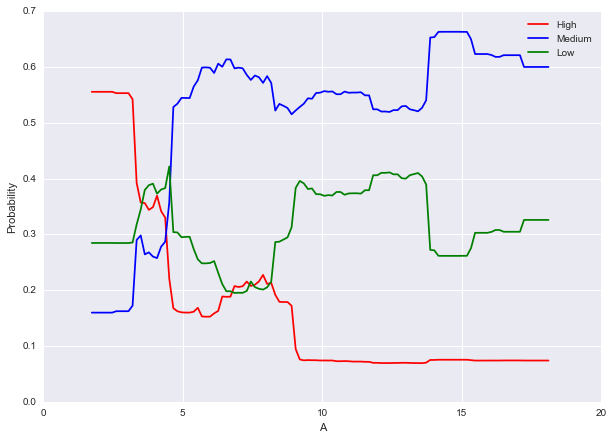

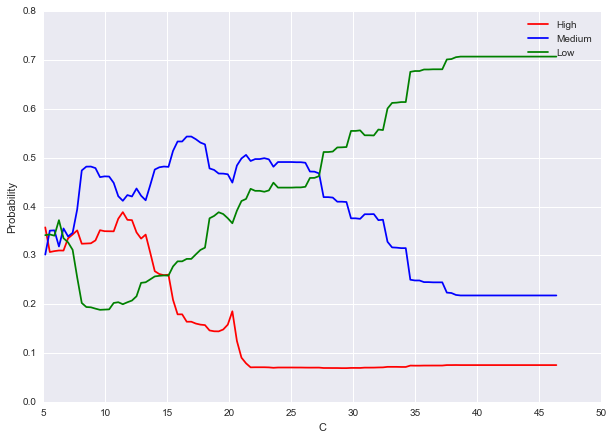

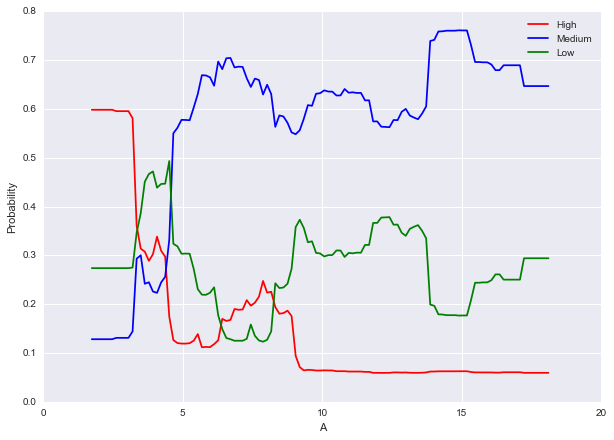

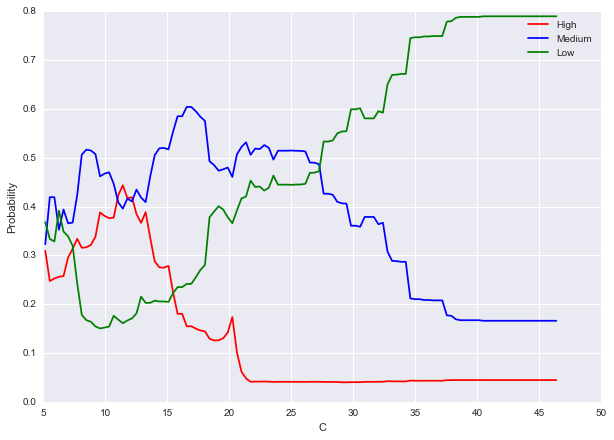

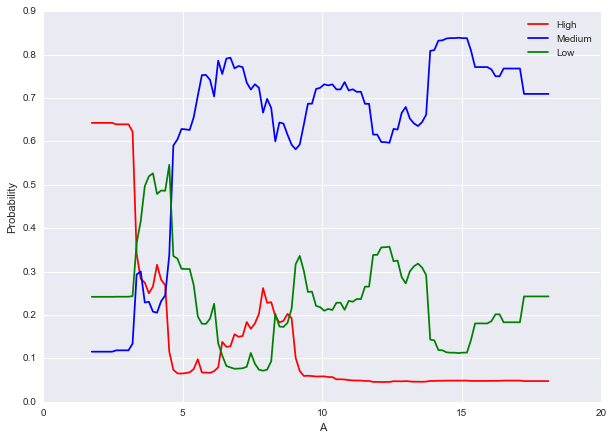

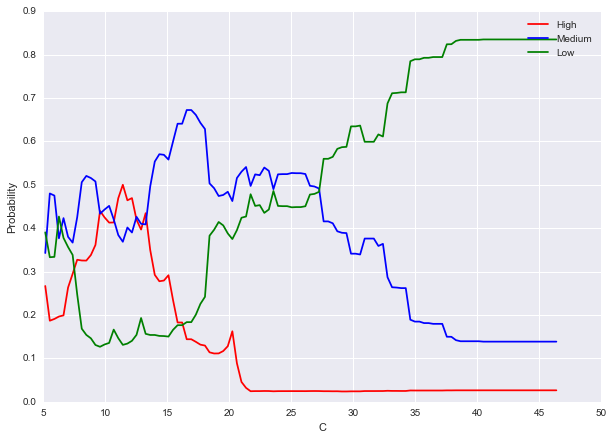

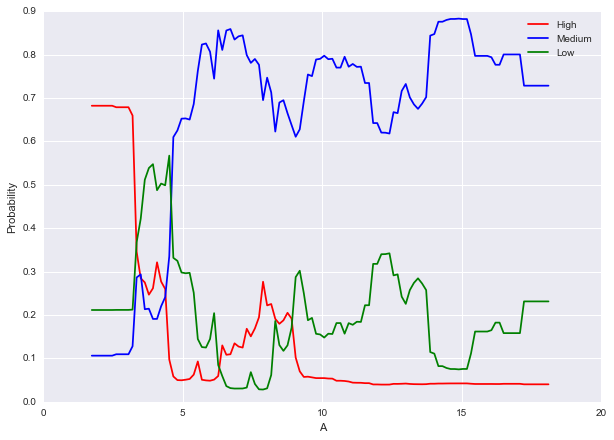

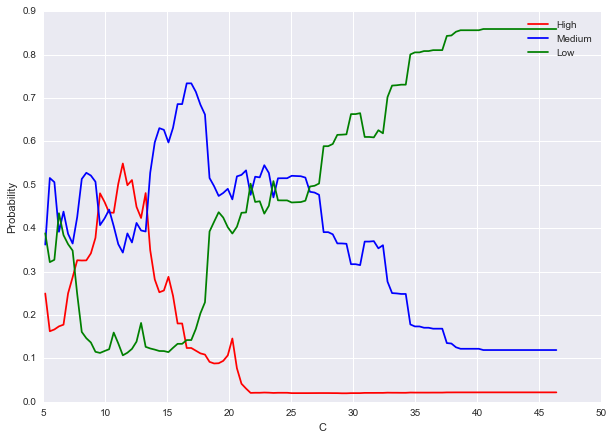

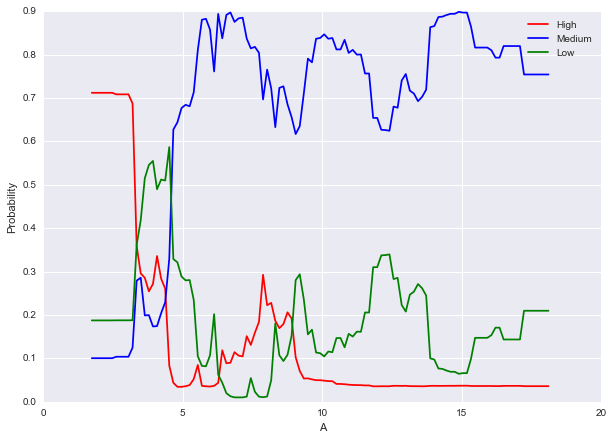

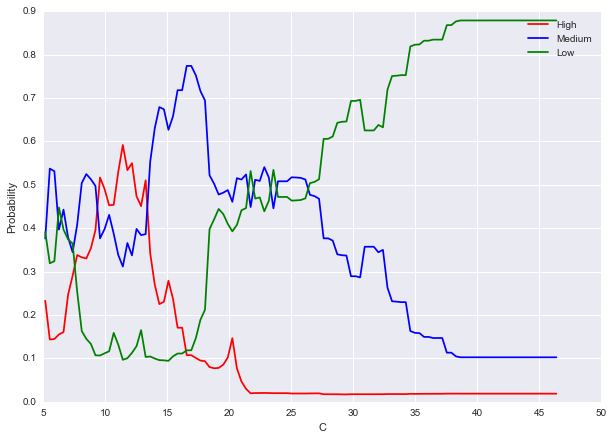

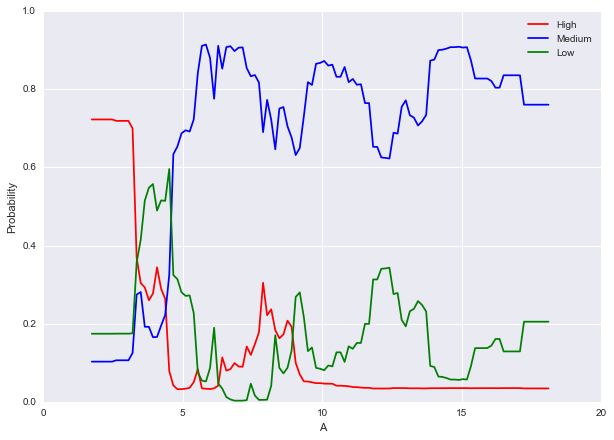

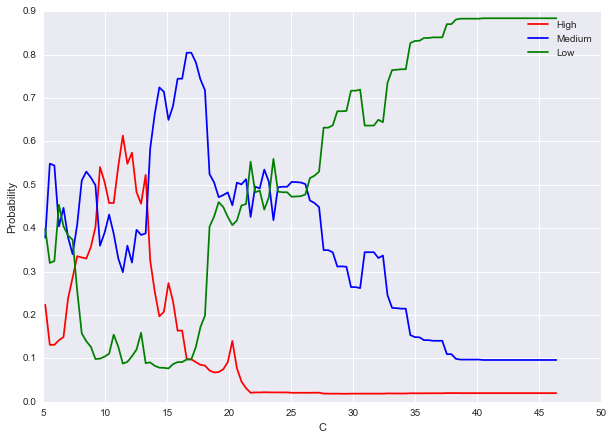

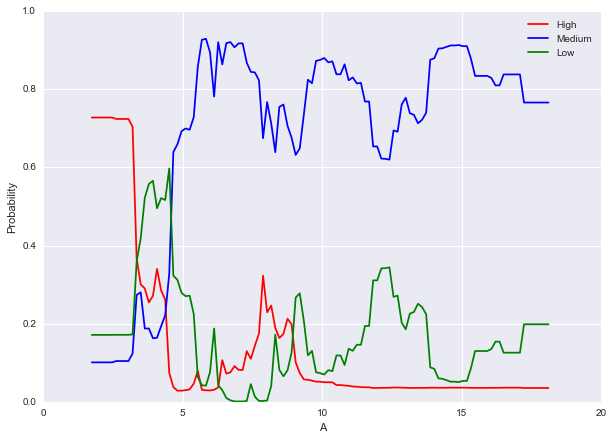

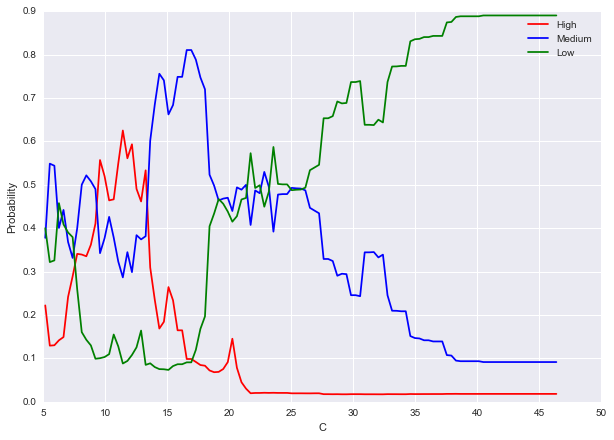

In [135]:
def Run_Forest(features,target,kf,x_train,x_test,y_train,y_test,depth):
    print 'Depth:',depth
    model = RandomForestClassifier(n_estimators=1000,max_features=1,
                                   max_depth=depth,class_weight='balanced_subsample',random_state=1)

    model = OneVsRestClassifier(model)

    print 'Cross validation score:',np.mean(cross_val_score(model,features,target,cv=kf))

    model.fit(x_train,y_train)
    pred = model.predict(x_test)

    print metrics.classification_report(y_test,pred)
    print 'Accuracy score:',metrics.accuracy_score(y_test,pred)
    print ''

    plot_pred_prob(model,features)
    
# We can tweak how deep our random forest can grow to control how accurate it is and how well it will generalize.
for depth in range(2,10):
    Run_Forest(L4_features,L4_target,L4_kf,L4_x_train,L4_x_test,L4_y_train,L4_y_test,depth)

# Conclusion and Probability Visualization:

Looking at the classification reports and cross validation score, it seems like none of our models performed particularly well; most models have a cross validation score of only around 50%. This suggests that we need more data or our features weren't particularly good at identifying the classes accurately. However, this type of results are common in biologics, and that is why it's so difficult to create the next big drug. Especially when we are trying to create a model where we are trying to detect outliers, which by definition does not occur very often and thus we won't have many data points for. 

Even though the CV scores for most models were only at around 50%, the models do provide some sort of insight into how our features impact our target given the precision and recall scores were not totally random. The precision and recall scores suggest that the models have **some** predictive power to catch the "High" outlier data points.

Out of all the models that were ran, Random Forest with a depth of 6 performed the best with a CV score of 0.57. However, the probability plots for Random Forest 6 is not very smooth, which suggests the foreset might be fitting to noise. At a depth of 5, we lose a little bit of accuracy, but the probability plot is a little bit smoother. In biologic studies, in addition to accuracy, interpretability and model simplicity are also very important. So we choose to Random Forest with depth of 5 as our final model because it has a good balance between accuracy and interprebility. 

Now that we are done with model assessment and selection, we can train the model with the complete data set.

In [136]:
# Fitting the model with our complete data set
model = RandomForestClassifier(n_estimators=1000,max_features=1,
                               max_depth=5,class_weight='balanced_subsample',random_state=1)
model.fit(L4_features,L4_target)

pred = model.predict(L4_x_test)

print metrics.classification_report(L4_y_test,pred,target_names=['High','Medium','Low'])
print 'Accuracy score:',metrics.accuracy_score(L4_y_test,pred)
print 'Probabilities class order:',model.classes_

             precision    recall  f1-score   support

       High       0.88      1.00      0.93         7
     Medium       1.00      0.91      0.95        11
        Low       0.95      0.95      0.95        20

avg / total       0.95      0.95      0.95        38

Accuracy score: 0.947368421053
Probabilities class order: ['High' 'Low' 'Medium']


The scores are artificially high because the model's predicting with values it has seen before. For more realistic accuracy score, we need to refer to the CV scores above during model assessment. 

Let's visualize the probabilities of any data points by varying the values of A and B while holding the other constant at its mean.

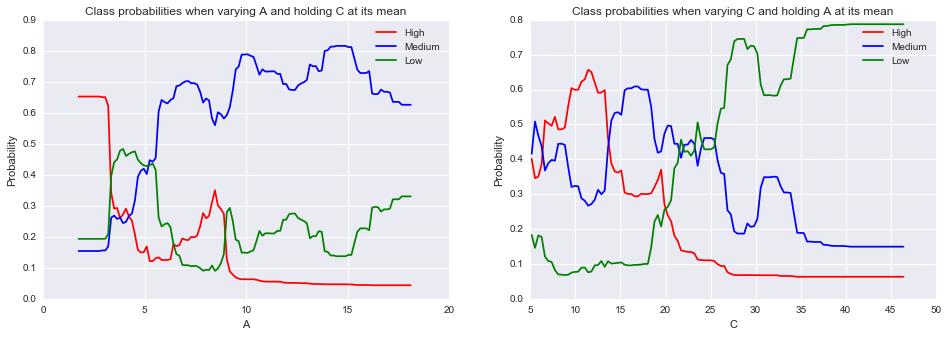

In [130]:
# Varying 'A' while holding 'C' at its mean
pred_prob = model.predict_proba(cartesian(L4_features,'A'))

figure,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

axes[0].set_title('Class probabilities when varying A and holding C at its mean')
axes[0].plot(np.linspace(min(L4_features['A']),max(L4_features['A']),num=len(pred_prob_A)),
         pred_prob[:,0],label='High',c='r')
axes[0].plot(np.linspace(min(L4_features['A']),max(L4_features['A']),num=len(pred_prob_A)),
         pred_prob[:,2],label='Medium',c='b')
axes[0].plot(np.linspace(min(L4_features['A']),max(L4_features['A']),num=len(pred_prob_A)),
         pred_prob[:,1],label='Low',c='g')
axes[0].set_xlabel('A'); axes[0].set_ylabel('Probability'); axes[0].legend()


# Varying 'B' while holding 'A' at its mean
pred_prob = model.predict_proba(cartesian(L4_features,'C'))

axes[1].set_title('Class probabilities when varying C and holding A at its mean')
axes[1].plot(np.linspace(min(L4_features['C']),max(L4_features['C']),num=len(pred_prob_A)),
         pred_prob[:,0],label='High',c='r')
axes[1].plot(np.linspace(min(L4_features['C']),max(L4_features['C']),num=len(pred_prob_A)),
         pred_prob[:,2],label='Medium',c='b')
axes[1].plot(np.linspace(min(L4_features['C']),max(L4_features['C']),num=len(pred_prob_A)),
         pred_prob[:,1],label='Low',c='g')
axes[1].set_xlabel('C'); axes[1].set_ylabel('Probability'); axes[1].legend()

plt.show()

The chart on the left shows the probability of a data point being a High, Medium, or Low when we vary the feature *A*. The same is true for the chart on the right but varying the feature *C*. 

**Interpreting the chart on the left:**

The red "High" line on the left drops off quickly as *A* reaches around 5, and the probabilities give way to Medium and Low classes. This suggest that if we can control *A* and keep it above 10, the chances of a data point being "High" drops off quickly. This also suggest that *A* has a big influence on the business target Y.

**Interpreting the chart on the right:**

Similar pattern of "High" chances decreasing as we increase *C*. In addition, the graph clearly shows that the probability of "Low" rises steadily as *C* increases. This pattern is just as important becuase the classes are mutually exclusive. By operating *C* above 30.0, we can ensure our product at least 60% chance of being a "Low". 

**Final words:**

It seems that if we can operate at the higher range of both *A* and *C*, the chances of getting a "High" data point will be very low. This is an important and conclusive finding for the business. 

Furthermore, in this study it was more important to use the classifier to help us identify trends in our data than building a model to help us make predictions. By characterizing how features *A* and *C* impact the target class, the team will conduct additional investigations and add new features in the future. 